<a href="https://colab.research.google.com/github/AnhDao1411/CSC14115/blob/main/extract_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York City Taxi Trip Duration

## Problem Statement

### Overview
This is a kaggle competition that challenges us to predict the taxi trip duration in New York city. Dataset is provided by the NYC taxi and Limousine commision for building a model.

Money prize: 30,000$.

Business motivation: providing good driving time estimation to
- Detect bottlenecks that appear in the taxi traffic network.
- Predict the taxi trip price. 

Input: a taxi trip with it's attributes. \
Output: trip duration in seconds. 
 
### Input and Output Data description

There are three files:
- train.csv: (1458644,11)
- test.csv: (625134,9)
- sample_submission.csv: (625134,2) 

| Column name | Description | 
| -------- | -------- | 
| id   | the id for each trip     |
| vendor_id   | the id provided Associated with the trip record     |
| pickup_datetime   | date and time when the meter was engaged     |
| dropoff_datetime   | date and time when the meter was disengaged    |
| passenger_count   | The number of passengers in the taxi    |
| pickup_longitude   | the longitude when the meter was engaged     |
| pickup_latitude   | the latitude when the meter was engaged   |
| dropoff_longitude   | the longitude when the meter was disengaged     |
| dropoff_latitude   | the latitude when the meter was disengaged     |
| store_and_fwd_flag   | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server  |
| trip_duration  | duration of the trip in seconds     |


- A record in train.csv

![](https://i.imgur.com/LtLFbTO.png)

- A record in test.csv
![](https://i.imgur.com/gEJR1jT.png)

- A record in sample_submission.csv
![](https://i.imgur.com/zwq0ezw.png)




### Evaluation Metric
- **Root Mean Squared Logarithmic Error** (RMSLE) is the metric was used to assess the result of this contest.

$$\epsilon = \sqrt{\frac{1}{n}\sum^{n}_{i=1}(log(p_i + 1) -log(a_i + 1)) ^2}$$

* With respect to:
    * $\epsilon$: RMSLE score
    * n: the number of records (trip duration's observations) in the dataset
    * $p_i$: the prediction of trip duration
    * $a_i$: the actual value of trip duration
    * log(x): natural logarithm (base is e)

* **The smaller the RMSLE value is, the better the model**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
from tqdm import tqdm
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
from math import radians, cos, sin, asin, sqrt
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score

import json

In [ ]:
# !unzip ../input/nyc-taxi-trip-duration/train.zip -d nyc-taxi-trip-duration
# !unzip ../input/nyc-taxi-trip-duration/test.zip -d nyc-taxi-trip-duration
# !unzip ../input/nyc-taxi-trip-duration/sample_submission.zip -d nyc-taxi-trip-duration
%cd /content/drive/MyDrive/CSC14115 - KHDLUD

/content/drive/.shortcut-targets-by-id/1X9WZOvukNSK-VHf1Vue6YDbHXMF8g2rc/CSC14115 - KHDLUD


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Explore data and Extract features

In [ ]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('./nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('./nyc-taxi-trip-duration/sample_submission.csv')

In [ ]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663


In [ ]:
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.99,40.73,-73.99,40.76,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.96,40.68,-73.96,40.66,N


### Basic information of datasets (train and test)

* Check whether the dataset has :
    * unique values for the id column.
    * missing values.
    * duplicate record.
    * the trip_duration values are consistent with pickup and dropoff datetime (only for the training dataset).

In [ ]:
def check_basic(df, df_type="train"):
    print("{} DF has {} rows and {} columns".format(df_type,df.shape[0], df.shape[1]))
    if df.id.nunique() == df.shape[0]:
        print("1. Id is unique")
    if not df.isnull().any().any(): 
        print("2. No missing value")
    if train.duplicated(keep='first').sum() == 0:
        print("3. No duplicate record")
    if df_type == 'train':
        trip_duration_diff = (pd.to_datetime(train.dropoff_datetime) - pd.to_datetime(train.pickup_datetime)).map(lambda x :x.total_seconds())
        if len(df[np.abs(trip_duration_diff.values - df['trip_duration'].values) > 1]) == 0:
            print("4. Trip_duration is consistent with pickup and dropoff times.")

In [ ]:
check_basic(train, df_type="train")

train DF has 1458644 rows and 11 columns
1. Id is unique
2. No missing value
3. No duplicate record
4. Trip_duration is consistent with pickup and dropoff times.


In [ ]:
check_basic(test, df_type="test")

test DF has 625134 rows and 9 columns
1. Id is unique
2. No missing value
3. No duplicate record


* Show the datatype of each column in dataset.

In [ ]:
print("Train:\n", train.dtypes, "\n")
print("Test:\n", test.dtypes)

Train:
 id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object 

Test:
 id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object


* Show the number of unique values in each column.

In [ ]:
train.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

#### Convert datatypes

* Because datatypes of `pickup_datetime` and `dropoff_datetime` are "**object**" which is difficult when we handle it with built-in functions of pandas $\rightarrow$ we convert it into "**datetime**" datatype to be easy to extract data from these columns.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

* We convert the datatype of the vendor_id column from **int64** to **object** (str) because:
    * vendor_id is the id provided Associated with the trip record.
    * this column only has 2 unique values, 1 and 2, but it does not mean 2 is bigger than 1.

In [ ]:
train['vendor_id'] = train['vendor_id'].astype(str)
test['vendor_id'] = test['vendor_id'].astype(str)

#### Statistics information of the train set

In [ ]:
train.describe(datetime_is_numeric = True)

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644,1458644,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,2016-04-01 10:10:24.940037120,2016-04-01 10:26:24.432310528,1.66,-73.97,40.75,-73.97,40.75,959.49
min,2016-01-01 00:00:17,2016-01-01 00:03:31,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,2016-02-17 16:46:04.249999872,2016-02-17 17:05:32.500000,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2016-04-01 17:19:40,2016-04-01 17:35:12,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2016-05-15 03:56:08.750000128,2016-05-15 04:10:51.750000128,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2016-06-30 23:59:39,2016-07-01 23:02:03,9.00,-61.34,51.88,-61.34,43.92,3526282.00
std,NaN,NaN,1.31,0.07,0.03,0.07,0.04,5237.43


* Get numeric, categorical column names

In [ ]:
num_cols = list(train.select_dtypes(exclude='object').columns)
cate_cols = list(train.select_dtypes(include='object').columns)
print("Num cols: ",num_cols)
print("Cate cols: ",cate_cols)

Num cols:  ['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']
Cate cols:  ['id', 'vendor_id', 'store_and_fwd_flag']


##### Numeric columns

In [ ]:
def value_percentages(col):
    val = col.groupby(by=col).count().sort_values(ascending=False)
    total = val.sum()
    return (((val / total)*100).round(1)).to_dict()

def num_values(col):
    return col.nunique()

def missing_percentage(col):
    per = col.isna().mean()*100
    return per.round(1)

In [ ]:
train[num_cols].agg([value_percentages, num_values])

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
value_percentages,"{2016-03-04 08:07:34: 0.0, 2016-01-12 18:48:44...","{2016-02-19 19:25:04: 0.0, 2016-05-16 19:40:28...","{1: 70.9, 2: 14.4, 5: 5.4, 3: 4.1, 6: 3.3, 4: ...","{-73.9822006225586: 0.0, -73.98213958740233: 0...","{40.77410125732422: 0.0, 40.774089813232415: 0...","{-73.98233032226561: 0.0, -73.98209381103516: ...","{40.774311065673835: 0.0, 40.77433013916016: 0...","{368: 0.1, 408: 0.1, 348: 0.1, 367: 0.1, 358: ..."
num_values,1380222,1380377,10,23047,45245,33821,62519,7417


* **Observation**:

$→$ The number of distinct values of `pickup_datetime` and `dropoff_datetime` takes up more than **90%** of the dataset $→$ extract the data of these columns to new columns (month, hour, day,...) to reduce the unique.

$→$ The value of longitude and latitude have **float64** datatypes $→$ it is difficult to compare.

##### Categorical columns

In [ ]:
train[cate_cols].agg([value_percentages, num_values])

,id,vendor_id,store_and_fwd_flag
value_percentages,"{'id0000001': 0.0, 'id2665099': 0.0, 'id266515...","{'2': 53.5, '1': 46.5}","{'N': 99.4, 'Y': 0.6}"
num_values,1458644,2,2


In [ ]:
train.groupby('store_and_fwd_flag')['trip_duration'].agg(['mean', 'min', 'max'])

,mean,min,max
store_and_fwd_flag,,,
N,958.82,1,3526282
Y,1080.76,2,9984


* **Observation**:

$→$ The `store_and_fwd_flag` column has only 2 values, N và Y. We decide to remove this column because:

1. The proportions of "N" and "Y" are 99.4% and 0.6%, respectively $→$ "N" dominant this column's value.
2. This column meaning is the flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server $→$ **does not affect** the `trip_duration`.
3. The average trip duration of these two groups has not much different.

### Extract new features

#### From `pickup_datetime`

In [ ]:
train.loc[:, 'pick_month'] = train['pickup_datetime'].dt.month
train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'day_of_month'] = train['pickup_datetime'].dt.day
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek

test.loc[:, 'pick_month'] = test['pickup_datetime'].dt.month
test.loc[:, 'hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'day_of_month'] = test['pickup_datetime'].dt.day
test.loc[:, 'day_of_week'] = test['pickup_datetime'].dt.dayofweek

In [ ]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_month,hour,day_of_month,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,3,17,14,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,6,0,12,6


* **Comment**:

$→$ Because this problem predicts the trip_duration so that the `dropoff_datetime` column is not necessary $→$ we **remove** this column.

In [ ]:
train.drop(['pickup_datetime', 'dropoff_datetime'], axis =1, inplace= True)
test.drop(['pickup_datetime'], axis =1, inplace= True)

#### Remove `store_and_fwd_flag`

In [ ]:
train.drop('store_and_fwd_flag', axis = 1, inplace=True)
test.drop('store_and_fwd_flag', axis = 1, inplace=True)

In [ ]:
train.head(1)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pick_month,hour,day_of_month,day_of_week
0,id2875421,2,1,-73.98,40.77,-73.96,40.77,455,3,17,14,0


#### Distance 

* The solution of Beluga about haversine distance and manhattan distance (in km).


In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

* `distance_haversine`, `distance_manhattan`: knowing the distance between two positions can help to estimate the duration => used to predict trip duration.


In [ ]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values,
                                                     test['pickup_longitude'].values,
                                                     test['dropoff_latitude'].values,
                                                     test['dropoff_longitude'].values)

In [ ]:
train.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values,
                                                              train['pickup_longitude'].values,
                                                              train['dropoff_latitude'].values,
                                                              train['dropoff_longitude'].values)

test.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                              test['pickup_longitude'].values,
                                                              test['dropoff_latitude'].values,
                                                              test['dropoff_longitude'].values)

In [ ]:
train[["id","distance_haversine","distance_manhattan"]].head(2)

,id,distance_haversine,distance_manhattan
0,id2875421,1.50,1.74
1,id2377394,1.81,2.43


* Determine the direction of pickup and dropoff positions and divide it into 8 bins (N, NE, E, SE, S, SW, W, NW):
    * Bearing_array function from solution of Beluga.
    * Assign direction for each degree.

    
* `direction`:  the direction of the trip has 8 directions => for each location, which direction do the riders need to move mainly => the traffic situation when moving in the directions at the pick-up point and the pick-up time => affect the prediction of travel time.
    



In [ ]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, 
                                          train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values, 
                                          train['dropoff_longitude'].values)

test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, 
                                          test['pickup_longitude'].values, 
                                          test['dropoff_latitude'].values, 
                                          test['dropoff_longitude'].values)

In [ ]:
train[["id","direction"]].describe()

,direction
count,1458644.00
mean,-15.67
std,104.49
min,-179.99
25%,-125.27
50%,8.20
75%,53.40
max,180.00


In [ ]:
new_df = train.copy()
train.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
train.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
train.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
train.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
train.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
train.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
train.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
train.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"


new_df = test.copy()
test.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
test.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
test.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
test.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
test.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
test.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
test.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
test.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"

In [ ]:
train["direction"].unique()

array(['N', 'SW', 'W', 'SE', 'NE', 'NW', 'E', 'S'], dtype=object)

#### Clustering area (from Beluga's notebook)

In [ ]:
train.loc[:, "avg_speed_h"] = 1000 * train["distance_haversine"] / train["trip_duration"]
train.loc[:, "avg_speed_m"] = 1000 * train["distance_manhattan"] / train["trip_duration"]

* Based on the tuple of longitude and latitude, we using KMeans in order to cluster pickup and dropoff positions to 100 groups respectively. Learning Kmeans with 500000 examples from the train set.
* From the area clustered, the average speed features can be extracted based on pickup, dropoff groups, and pickup hour. These features can be used in test set.

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

* `pickup_cluster`, `dropoff_cluster`: group of nearest/similar pick-up and drop-off latitudes and longitudes ==> We assume that location in that group has the same traffic and has the same impact on trip duration.

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#### Calculate area's speed and number of trips (from Beluga's notebook)

* New features of speed (use average speed of haversine distance) groups by: `hour` - `pickup_cluster`, `hour` - `dropoff_cluster`, `pickup_cluster` - `dropoff_cluster`.
* To avoid learning model being overfitted, we only keep the shared values of each group with a count over 100.
* Average speed of haversine distance is calculated on the train set so that the test set does not leak.

* `avg_speed_h_hour_pickup_cluster`, `avg_speed_h_hour_dropoff_cluster`, `avg_speed_h_pickup_cluster_dropoff_cluster`: because **t = s/v**. Estimate the average speed based on pickup hour, pickup and dropoff clusters. These values are calculated using `avg_speed_h`. Although the `avg_speed_h` is invalid due to using the target column, these values are the average of group by and not directly inferred from them => we can assume these as an estimation for speed => used to predict the trip duration. 

* `cnt_hour_pickup_cluster`, `cnt_hour_dropoff_cluster`, `cnt_pickup_cluster_dropoff_cluster`: the number of trips in each attribute pair => affects the travel time because it shows how crowded the traffic is at the hour of pick-up, pick-up and drop-off area => used to predict the trip duration.

In [ ]:
for gby_cols in [['hour', 'pickup_cluster'],  ['hour', 'dropoff_cluster'], ['pickup_cluster', 'dropoff_cluster']]:
    # harvasine
    coord_speed_h = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed_h, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [ ]:
for gby_cols in [['hour', 'pickup_cluster'],  ['hour', 'dropoff_cluster'], ['pickup_cluster', 'dropoff_cluster']]:
    # manhattan
    coord_speed_m = train.groupby(gby_cols).mean()[['avg_speed_m']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed_m, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_m_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [ ]:
num_cols = list(train.select_dtypes(exclude='object').columns)
cate_cols = list(train.select_dtypes(include='object').columns)

### Visualize data

#### Histogram all numberic columns

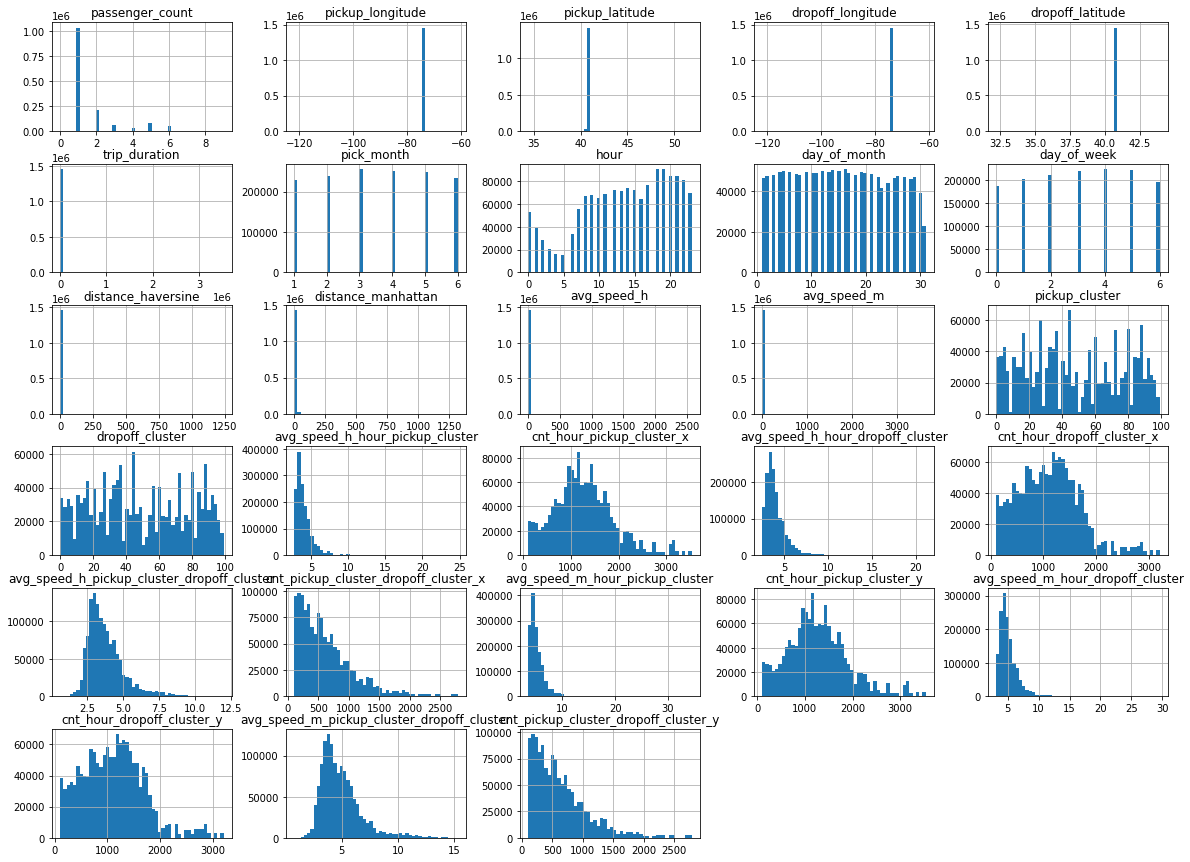

In [ ]:
train[num_cols].hist(figsize=(20, 15), bins = 50)
plt.show()


* Scatter of each numeric column for the number of each value.

In [ ]:
def draw_chart(df, fig_size = (15,15)):
    temp = list(df.columns)
    figure, axis = plt.subplots(len(temp)//2 if len(temp) % 2 == 0 else len(temp)//2 + 1, 2, figsize = fig_size)
    color = ['#582f0e','#936639','#f3722c','#c2c5aa','#414833','#457b9d','#ffb703','#e63946', '#c77dff','#55a630','#f72585','#ffa69e','#4d908e','#7f5539','#b5e48c','#b6ad90','#38b000','#a84c32','#a84c32','#471f13','#8c842d','#408061']
    for i, col in enumerate(temp):
        t = df[col].value_counts()
        axis[i//2, i%2].scatter(list(t.index), t.values, color = color[i])
        axis[i//2, i%2].set_title(col)
    if len(temp) %2 !=0:
        figure.delaxes(axis[len(temp)//2,1])
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.show()

In [ ]:
# draw_chart(train[num_cols], (16,25));

 **Comment**:

- pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude have some values which dominate because in this problem we focus on New York city.
- People in New York tends to go alone (passenger = 1)
- pick_month: in March, the number of people using Taxi is the highest.
- hour: less people uses Taxi at 5am and more at 16-20pm.
- day_of_week: on Monday and Sunday, less people uses Taxi
- day_of_month: at the end of a month, the number of human using Taxi decreases.
- 2 types of distance and average speed have no much different.
- Trip duration is calcuated by second so the range is quite big (1e6) and there are some values that occur most of the time.

#### Trip duration column

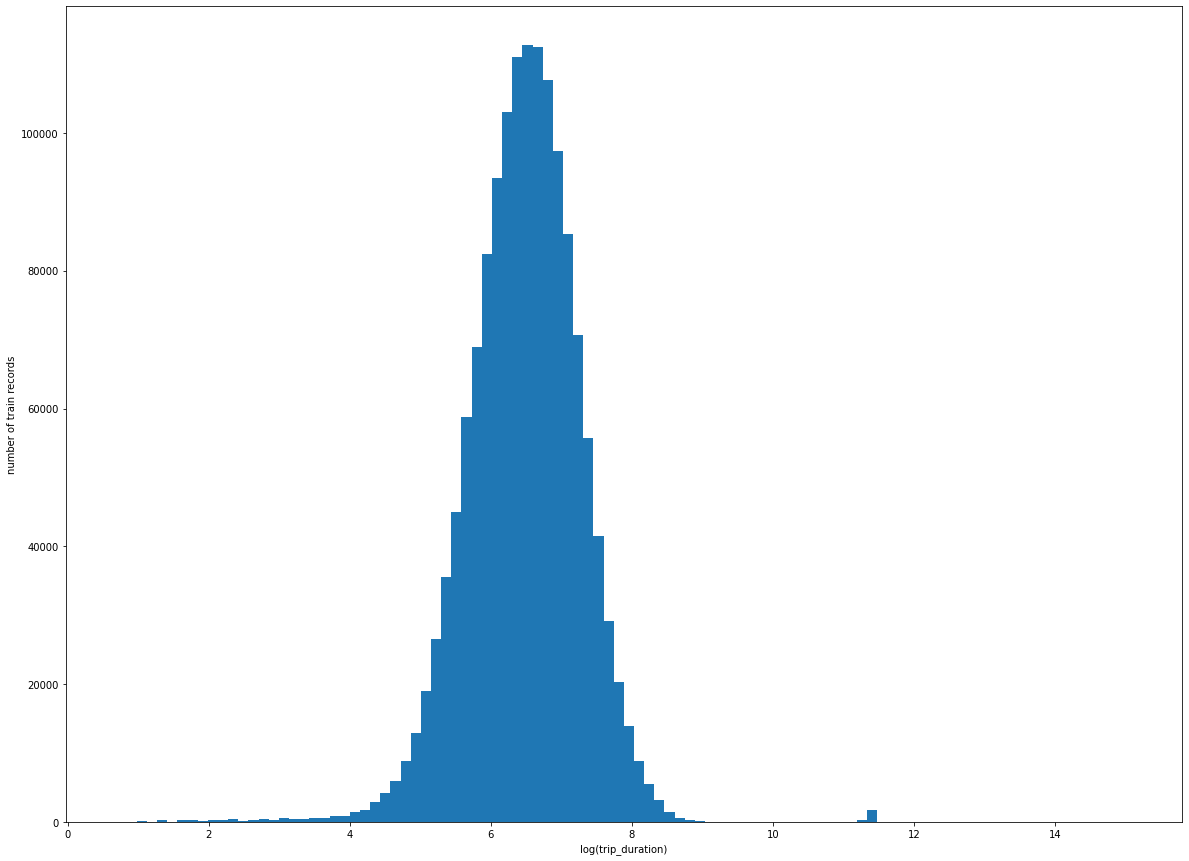

In [ ]:
train_log_trip_duration = np.log(train['trip_duration'].values + 1)
plt.hist(train_log_trip_duration, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

### Choose columns affect trip duration


In [ ]:
print(len(train.columns)) 
train.columns

31


Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'pick_month', 'hour', 'day_of_month', 'day_of_week',
       'distance_haversine', 'distance_manhattan', 'direction', 'avg_speed_h',
       'avg_speed_m', 'pickup_cluster', 'dropoff_cluster',
       'avg_speed_h_hour_pickup_cluster', 'cnt_hour_pickup_cluster_x',
       'avg_speed_h_hour_dropoff_cluster', 'cnt_hour_dropoff_cluster_x',
       'avg_speed_h_pickup_cluster_dropoff_cluster',
       'cnt_pickup_cluster_dropoff_cluster_x',
       'avg_speed_m_hour_pickup_cluster', 'cnt_hour_pickup_cluster_y',
       'avg_speed_m_hour_dropoff_cluster', 'cnt_hour_dropoff_cluster_y',
       'avg_speed_m_pickup_cluster_dropoff_cluster',
       'cnt_pickup_cluster_dropoff_cluster_y'],
      dtype='object')

* **The effect of each column on predicting trip_duration**:
    * `id`: id of trip => does not related to trip duration => do not use to predict trip duration.
       
    * Features from pickup_datetime: `pick_month`, `hour`, `day_of_month`, `day_of_week`: this is the basic information of time => Based on those, ***we can know on which time, the number of vehicles will increase***. We do not add minute column because this column is too detail or that can be known by other previous added columns => Feed to model.
    
    * `avg_speed_h`, `avg_speed_m`: do not use these columns to predict the trip duration because they are calculated based on the target column.

=> Features will be rejected: `id`, `trip_duration`, `avg_speed_h`,`avg_speed_m`.


In [ ]:
train = train.drop(columns = ['avg_speed_h',"avg_speed_m"], axis =0 )

In [ ]:
# Duplicate count trips column from mahattan distance
train = train.drop(columns = ['cnt_hour_pickup_cluster_y',"cnt_hour_dropoff_cluster_y", "cnt_pickup_cluster_dropoff_cluster_y"])
test = test.drop(columns = ['cnt_hour_pickup_cluster_y',"cnt_hour_dropoff_cluster_y", "cnt_pickup_cluster_dropoff_cluster_y"])

In [ ]:
%cd /content/drive/MyDrive/CSC14115 - KHDLUD/WEEK/Split_code

/content/drive/.shortcut-targets-by-id/1X9WZOvukNSK-VHf1Vue6YDbHXMF8g2rc/CSC14115 - KHDLUD/WEEK/Split_code


In [ ]:
# Write features_train.csv
# Write features_test.csv

train.to_csv('features_train.csv', index=False)
test.to_csv('features_test.csv', index=False)